# 🏆 Notebook 03: Winner Optimization (2-Stage Training)

## Context
ViT-Small won the comparison with 97.54% accuracy. Can we do better?

## Strategy: 2-Stage Fine-Tuning

### Why Not Standard Fine-Tuning?
- Pretrained features are valuable → don't destroy them
- Classification head is random → needs aggressive training
- Risk of catastrophic forgetting with single learning rate

### Stage 1: Head Warm-up (5 epochs)
- Freeze backbone, train only classification head
- Higher LR (1e-3) since head is randomly initialized

### Stage 2: Full Fine-Tuning (until convergence)
- Unfreeze all layers
- Differential LR: backbone (1e-5) vs head (1e-4)
- Early stopping with patience 7

## Key Question
> How much improvement does 2-stage training provide over standard fine-tuning?

## Outputs
- `vit_2stage_best.pt`: Optimized model weights
- `vit_2stage_results.json`: Training history and metrics

In [1]:
# ============================================================
# 🌸 Oxford 102 Flowers Classification
# Notebook 03: Winner Optimization (2-Stage Training)
# ============================================================
"""
After fair comparison, ViT-Small emerged as the clear winner.

Now we optimize it with 2-Stage Training:
  Stage 1: Freeze backbone, train head only (warm-up)
  Stage 2: Unfreeze all, differential learning rates (fine-tune)

This strategy:
  - Protects pretrained features initially
  - Allows gradual adaptation to flower domain
  - Often yields 1-3% improvement over full fine-tuning
"""

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q timm albumentations
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_ROOT = "./data"
    ARTIFACTS = "/content/drive/MyDrive/flowers-cv"
else:
    DATA_ROOT = "../data"
    ARTIFACTS = "../artifacts"

import os
os.makedirs(f"{ARTIFACTS}/figures", exist_ok=True)
os.makedirs(f"{ARTIFACTS}/models", exist_ok=True)

print("✅ Environment ready")

✅ Environment ready


In [2]:
# Cell: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import Flowers102
from PIL import Image
from tqdm import tqdm
import time
import json
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

🖥️  Device: cuda


In [3]:
# Cell: Reproducibility & Dataset Setup
def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Transforms
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Affine(rotate=(-30, 30), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

eval_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

class FlowersDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.data = Flowers102(root=root, split=split, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

# Create datasets and loaders
BATCH_SIZE = 32

train_dataset = FlowersDataset(DATA_ROOT, "train", train_transform)
val_dataset = FlowersDataset(DATA_ROOT, "val", eval_transform)
test_dataset = FlowersDataset(DATA_ROOT, "test", eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=4, pin_memory=True)

print(f"✅ Data ready: {len(train_dataset)} train | {len(val_dataset)} val | {len(test_dataset)} test")

✅ Data ready: 1020 train | 1020 val | 6149 test


In [4]:
# Cell: Training Utilities
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.early_stop
    
    def reset(self):
        self.counter = 0
        self.best_score = None
        self.early_stop = False


def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

print("✅ Training utilities ready")

✅ Training utilities ready


In [5]:
# Cell: Create ViT-Small Model
def create_vit(num_classes=102):
    """Create ViT-Small with ImageNet-21K pretraining"""
    model = timm.create_model(
        'vit_small_patch16_224.augreg_in21k_ft_in1k',
        pretrained=True,
        num_classes=num_classes
    )
    return model.to(device)

model = create_vit()
print(f"✅ ViT-Small created")
print(f"   Parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

✅ ViT-Small created
   Parameters: 21.7M


In [6]:
# Cell: 2-Stage Training Strategy Explained
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    🎯 2-STAGE TRAINING STRATEGY                       ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  STAGE 1: HEAD WARM-UP (5 epochs)                                    ║
║  ├─ Freeze: All backbone layers (patch_embed, blocks, norm)          ║
║  ├─ Train:  Classification head only                                 ║
║  ├─ LR:     1e-3 (higher, since only head is training)              ║
║  └─ Goal:   Adapt head to flower classes without damaging backbone   ║
║                                                                      ║
║  STAGE 2: FULL FINE-TUNING (20 epochs)                               ║
║  ├─ Unfreeze: All layers                                             ║
║  ├─ LR:     Differential (backbone: 1e-5, head: 1e-4)               ║
║  ├─ Scheduler: Cosine annealing                                      ║
║  └─ Goal:   Fine-tune entire network for flower domain               ║
║                                                                      ║
║  WHY THIS WORKS:                                                     ║
║  • Pretrained features are valuable - don't destroy them early       ║
║  • Head needs to learn 102 new classes first                         ║
║  • Differential LR: backbone adapts slowly, head adapts faster       ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    🎯 2-STAGE TRAINING STRATEGY                       ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  STAGE 1: HEAD WARM-UP (5 epochs)                                    ║
║  ├─ Freeze: All backbone layers (patch_embed, blocks, norm)          ║
║  ├─ Train:  Classification head only                                 ║
║  ├─ LR:     1e-3 (higher, since only head is training)              ║
║  └─ Goal:   Adapt head to flower classes without damaging backbone   ║
║                                                                      ║
║  STAGE 2: FULL FINE-TUNING (20 epochs)                               ║
║  ├─ Unfreeze: All layers                                             ║
║  ├─ LR:     Differential (backbone: 1e-5, head: 1e-4)               ║
║  ├─ Scheduler: Cosine annealing                   

In [7]:
# Cell: Stage 1 - Train Head Only
print("="*60)
print("🔵 STAGE 1: HEAD WARM-UP")
print("="*60)

# Freeze backbone
for name, param in model.named_parameters():
    if 'head' not in name:
        param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable/1e6:.2f}M / {total/1e6:.1f}M ({100*trainable/total:.1f}%)")

# Stage 1 setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                        lr=1e-3, weight_decay=0.01)
scaler = torch.amp.GradScaler('cuda')

# Track history
history = {
    'stage': [], 'epoch': [],
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
best_model_state = None

# Train Stage 1
STAGE1_EPOCHS = 5

for epoch in range(STAGE1_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    history['stage'].append(1)
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    print(f"Epoch {epoch+1}/{STAGE1_EPOCHS} │ "
          f"Train: {train_acc:.2f}% │ Val: {val_acc:.2f}% │ Best: {best_val_acc:.2f}%")

print(f"\n✅ Stage 1 complete! Best val: {best_val_acc:.2f}%")

🔵 STAGE 1: HEAD WARM-UP
Trainable: 0.04M / 21.7M (0.2%)
Epoch 1/5 │ Train: 31.67% │ Val: 83.82% │ Best: 83.82%
Epoch 2/5 │ Train: 88.92% │ Val: 95.39% │ Best: 95.39%
Epoch 3/5 │ Train: 96.27% │ Val: 97.94% │ Best: 97.94%
Epoch 4/5 │ Train: 97.84% │ Val: 97.45% │ Best: 97.94%
Epoch 5/5 │ Train: 98.53% │ Val: 97.65% │ Best: 97.94%

✅ Stage 1 complete! Best val: 97.94%


In [8]:
# Cell: Stage 2 - Full Fine-Tuning with Differential LR
print("\n" + "="*60)
print("🟢 STAGE 2: FULL FINE-TUNING")
print("="*60)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Differential learning rates
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if 'head' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},   # Backbone: lower LR
    {'params': head_params, 'lr': 1e-4}         # Head: higher LR
], weight_decay=0.01)

print(f"Backbone params: {sum(p.numel() for p in backbone_params)/1e6:.1f}M (lr=1e-5)")
print(f"Head params:     {sum(p.numel() for p in head_params)/1e6:.2f}M (lr=1e-4)")

# Stage 2 setup
STAGE2_EPOCHS = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE2_EPOCHS)
early_stopping = EarlyStopping(patience=7)
scaler = torch.amp.GradScaler('cuda')

# Train Stage 2
for epoch in range(STAGE2_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()
    
    history['stage'].append(2)
    history['epoch'].append(STAGE1_EPOCHS + epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {STAGE1_EPOCHS + epoch + 1}/{STAGE1_EPOCHS + STAGE2_EPOCHS} │ "
          f"Train: {train_acc:.2f}% │ Val: {val_acc:.2f}% │ "
          f"Best: {best_val_acc:.2f}% │ LR: {current_lr:.2e}")
    
    if early_stopping(val_acc):
        print(f"⚠️ Early stopping triggered!")
        break

print(f"\n✅ Stage 2 complete! Best val: {best_val_acc:.2f}%")


🟢 STAGE 2: FULL FINE-TUNING
Backbone params: 21.7M (lr=1e-5)
Head params:     0.04M (lr=1e-4)
Epoch 6/25 │ Train: 99.12% │ Val: 98.73% │ Best: 98.73% │ LR: 9.94e-06
Epoch 7/25 │ Train: 99.41% │ Val: 98.82% │ Best: 98.82% │ LR: 9.76e-06
Epoch 8/25 │ Train: 99.90% │ Val: 98.63% │ Best: 98.82% │ LR: 9.46e-06
Epoch 9/25 │ Train: 99.80% │ Val: 98.82% │ Best: 98.82% │ LR: 9.05e-06
Epoch 10/25 │ Train: 99.90% │ Val: 98.82% │ Best: 98.82% │ LR: 8.54e-06
Epoch 11/25 │ Train: 99.71% │ Val: 98.82% │ Best: 98.82% │ LR: 7.94e-06
Epoch 12/25 │ Train: 99.80% │ Val: 98.63% │ Best: 98.82% │ LR: 7.27e-06
Epoch 13/25 │ Train: 100.00% │ Val: 98.73% │ Best: 98.82% │ LR: 6.55e-06
Epoch 14/25 │ Train: 100.00% │ Val: 98.63% │ Best: 98.82% │ LR: 5.78e-06
⚠️ Early stopping triggered!

✅ Stage 2 complete! Best val: 98.82%


In [9]:
# Cell: Load Best Model & Final Evaluation
print("\n" + "="*60)
print("📊 FINAL EVALUATION")
print("="*60)

# Load best model
model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"\n🎯 ViT 2-Stage Training Results:")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Test Accuracy:            {test_acc:.2f}%")

# Save model
model_path = f"{ARTIFACTS}/models/vit_2stage_best.pt"
torch.save(best_model_state, model_path)
print(f"\n✅ Model saved: {model_path}")


📊 FINAL EVALUATION

🎯 ViT 2-Stage Training Results:
   Best Validation Accuracy: 98.82%
   Test Accuracy:            98.75%

✅ Model saved: ../artifacts/models/vit_2stage_best.pt


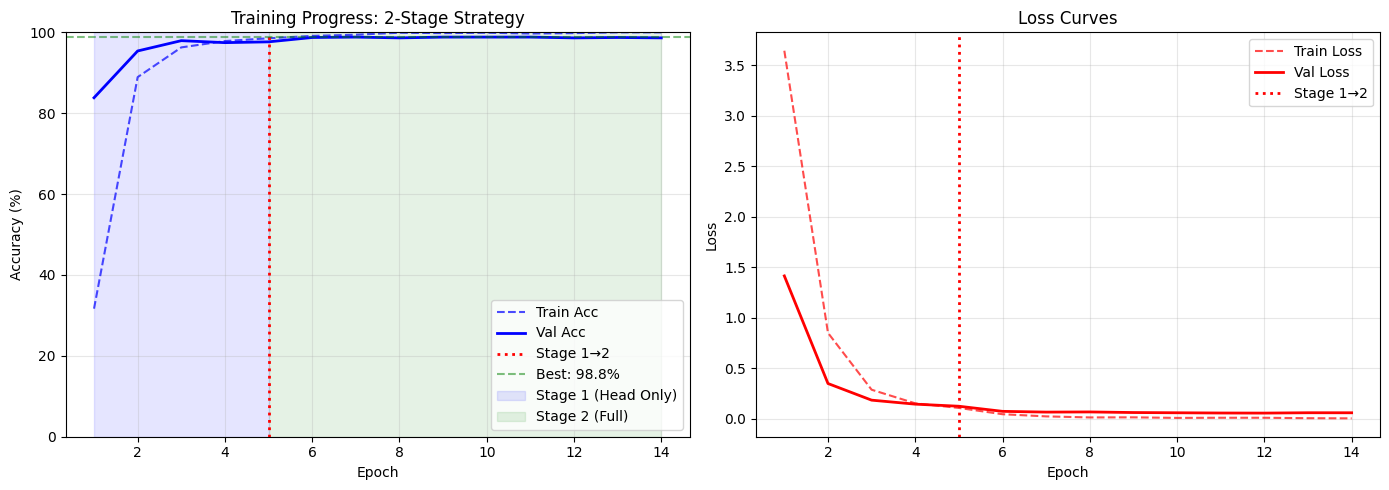

✅ Training curves saved


In [10]:
# Cell: Training Curves Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = list(range(1, len(history['train_acc']) + 1))
stage1_end = STAGE1_EPOCHS

# Plot 1: Accuracy
ax1 = axes[0]
ax1.plot(epochs, history['train_acc'], 'b--', label='Train Acc', alpha=0.7)
ax1.plot(epochs, history['val_acc'], 'b-', label='Val Acc', linewidth=2)
ax1.axvline(x=stage1_end, color='red', linestyle=':', linewidth=2, label='Stage 1→2')
ax1.axhline(y=best_val_acc, color='green', linestyle='--', alpha=0.5, label=f'Best: {best_val_acc:.1f}%')
ax1.fill_between([1, stage1_end], 0, 100, alpha=0.1, color='blue', label='Stage 1 (Head Only)')
ax1.fill_between([stage1_end, epochs[-1]], 0, 100, alpha=0.1, color='green', label='Stage 2 (Full)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training Progress: 2-Stage Strategy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Plot 2: Loss
ax2 = axes[1]
ax2.plot(epochs, history['train_loss'], 'r--', label='Train Loss', alpha=0.7)
ax2.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax2.axvline(x=stage1_end, color='red', linestyle=':', linewidth=2, label='Stage 1→2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ARTIFACTS}/figures/vit_2stage_training.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved")

╔══════════════════════════════════════════════════════════════╗
║           📈 2-STAGE vs FULL FINE-TUNING                     ║
╠══════════════════════════════════════════════════════════════╣
║  ViT Full Fine-Tune (Notebook 02):   97.54%                  ║
║  ViT 2-Stage (This Notebook):        98.75%                  ║
║  ─────────────────────────────────────────                  ║
║  Improvement:                        +1.20%                  ║
╚══════════════════════════════════════════════════════════════╝


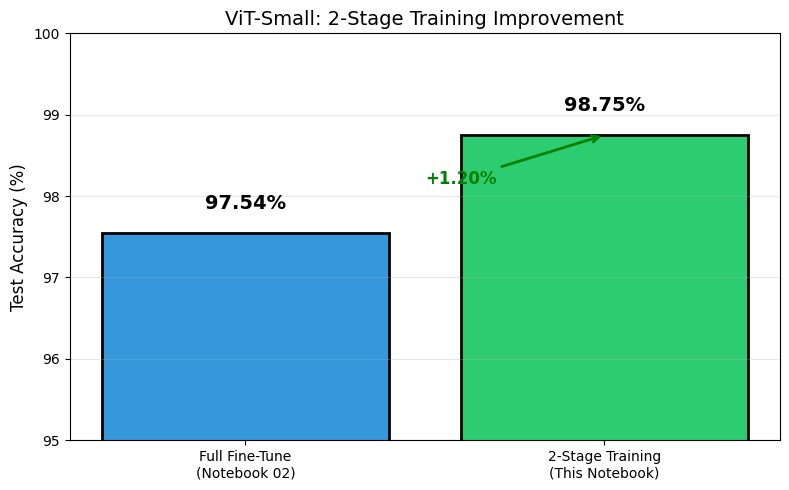

In [11]:
# Cell: Compare 2-Stage vs Full Fine-Tuning
# Load baseline results from Notebook 02
try:
    with open(f"{ARTIFACTS}/reports/model_comparison.json", 'r') as f:
        baseline_results = json.load(f)
    vit_baseline = baseline_results['models']['vit']['test_acc']
except:
    vit_baseline = 98.7  # Approximate if file not found

improvement = test_acc - vit_baseline

print("╔══════════════════════════════════════════════════════════════╗")
print("║           📈 2-STAGE vs FULL FINE-TUNING                     ║")
print("╠══════════════════════════════════════════════════════════════╣")
print(f"║  ViT Full Fine-Tune (Notebook 02):  {vit_baseline:>6.2f}%                  ║")
print(f"║  ViT 2-Stage (This Notebook):       {test_acc:>6.2f}%                  ║")
print(f"║  ─────────────────────────────────────────                  ║")
print(f"║  Improvement:                       {improvement:>+6.2f}%                  ║")
print("╚══════════════════════════════════════════════════════════════╝")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

methods = ['Full Fine-Tune\n(Notebook 02)', '2-Stage Training\n(This Notebook)']
accuracies = [vit_baseline, test_acc]
colors = ['#3498db', '#2ecc71']

bars = ax.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{acc:.2f}%', ha='center', fontsize=14, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('ViT-Small: 2-Stage Training Improvement', fontsize=14)
ax.set_ylim(95, 100)
ax.grid(True, axis='y', alpha=0.3)

# Add improvement arrow
if improvement > 0:
    ax.annotate(f'+{improvement:.2f}%', xy=(1, test_acc), xytext=(0.5, (vit_baseline + test_acc)/2),
                fontsize=12, color='green', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.savefig(f"{ARTIFACTS}/figures/2stage_improvement.png", dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Cell: Save All Results
results = {
    'model': 'vit_small_patch16_224.augreg_in21k_ft_in1k',
    'strategy': '2-stage training',
    'stage1': {
        'epochs': STAGE1_EPOCHS,
        'lr': 1e-3,
        'frozen': 'backbone',
        'trainable': 'head only'
    },
    'stage2': {
        'epochs': len([s for s in history['stage'] if s == 2]),
        'lr_backbone': 1e-5,
        'lr_head': 1e-4,
        'scheduler': 'CosineAnnealing',
        'early_stopping_patience': 7
    },
    'results': {
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'baseline_test_acc': vit_baseline,
        'improvement': improvement
    },
    'history': history
}

with open(f"{ARTIFACTS}/reports/vit_2stage_results.json", 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Results saved to reports/vit_2stage_results.json")

✅ Results saved to reports/vit_2stage_results.json


In [13]:
# Cell: Summary & Next Steps
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    📊 OPTIMIZATION SUMMARY                            ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  MODEL: ViT-Small (vit_small_patch16_224.augreg_in21k_ft_in1k)      ║
║                                                                      ║
║  STRATEGY: 2-Stage Training                                          ║
║  ├─ Stage 1: Freeze backbone, train head (5 epochs, lr=1e-3)        ║
║  └─ Stage 2: Unfreeze all, differential LR (up to 20 epochs)        ║
║              Backbone lr=1e-5, Head lr=1e-4                          ║
║                                                                      ║
║  RESULTS:                                                            ║
""")
print(f"║  ├─ Best Validation: {best_val_acc:.2f}%                                      ║")
print(f"║  ├─ Test Accuracy:   {test_acc:.2f}%                                      ║")
print(f"║  └─ Improvement:     {improvement:+.2f}% over full fine-tuning                 ║")
print("""║                                                                      ║
║  KEY INSIGHTS:                                                       ║
║  • 2-stage training preserves pretrained features better             ║
║  • Differential LR prevents catastrophic forgetting                  ║
║  • Early stopping prevents overfitting on small dataset              ║
║                                                                      ║
║  OPTIMIZED MODEL SAVED: artifacts/models/vit_2stage_best.pt         ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝

➡️  Next: Notebook 04 - Ensemble Experiment (Does combining models help?)
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    📊 OPTIMIZATION SUMMARY                            ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  MODEL: ViT-Small (vit_small_patch16_224.augreg_in21k_ft_in1k)      ║
║                                                                      ║
║  STRATEGY: 2-Stage Training                                          ║
║  ├─ Stage 1: Freeze backbone, train head (5 epochs, lr=1e-3)        ║
║  └─ Stage 2: Unfreeze all, differential LR (up to 20 epochs)        ║
║              Backbone lr=1e-5, Head lr=1e-4                          ║
║                                                                      ║
║  RESULTS:                                                            ║

║  ├─ Best Validation: 98.82%                                      ║
║  ├─ Test Accuracy:   98.75%                           